# Newton Method for GLM (General Linear Model)
### Created by ZhuXiangqi on 2018/9/16
* Newton Method
* Least-Graph (Naive Linear Model)
* Logistic (General Linear Model)

In [1]:
import numpy as np
from scipy.stats import chi2
from scipy.stats import t
from scipy.stats import f
from scipy.stats import norm
np.random.seed(2018)

## I. Newton Method
Class *NewtonMethod* is built for finding the optimal solution of **MOOP** (multi-objective optimization problem).   
With different objective, the *_derivative* function (gradient) and *_Hessian* function are varied. So class *NewtonMethod* is a parent class where these two function in it can be inherited.   
Newton method is based on the second order Taylor expansion of the $k$th estimation optimal solution, and the next estimation can be found according to the first and second order derivative of objective function, which can be regarded as gradient and Hessian matrix when it goes to multi-objective situations.   
* Gradient in iteration $k$: 
$$g_k=\triangle f(X_k)$$
* Hessian matrix in iteration $k$:
$$H_k=\triangle ^2 f(X_k)$$

Where $f$ is the objective funtion, $X_k$ is the solution of the $k$th iteration.   
If $H_k$ is not singular matrix, the form of the $k+1$th iteration is:
$$X_{k+1}=X_k-H_k^{-1}g_k$$


In [2]:
class NewtonMethod(object):
    #
    # Created by ZhuXiangqi 2018.9.16
    #
    # initiate iter number and threshold
    def __init__(self, iters = 20, if_append = True, eps = 1e-5):
        self.iters = iters
        self.eps = eps
        self.if_append = if_append
        
    # test for derivative, Hessian and objective functions
    def _derivative(self, X, y, beta):
        raise NotImplementedError
    def _Hessian(self, X, beta):
        raise NotImplementedError
        
    # F-test, variance and factors tests of Linear model
    def _test(self, X, y, beta):
        raise NotImplementedError
#     def _Objfunc(self,X,y,beta):
#         raise NotImplementedError
        
    # test iter (print)
    def test_str(self):
        return ("%s(iters = %s, if_append = %s, tol = %s)"
                % (self.__class__.__name__, self.iters, self.if_append, self.eps))  
    
    # newton method fit iteration
    def fit(self, X, y, beta_init = None, verbose = 1):
        self.n, p = X.shape
        if self.if_append:
            self.p = p + 1
            beta = np.zeros(self.p).reshape(-1, 1)
            X = np.append(np.ones((self.n, 1)), X, axis = 1)
        else:
            self.p = p 
            beta = np.zeros(self.p).reshape(-1, 1)
        if not beta_init is None:
            for i in np.arange(len(beta_init)):
                beta[i] = beta_init[i]
        k = 1
#         obj2 = np.inf
        eps=np.inf
        while 1:
            g = self._derivative(X, y, beta)
            H = self._Hessian(X, beta)
            #print(H)
            beta_update = beta - np.dot(np.linalg.inv(H), g)
            if verbose:
                print("iteration %s:\n %s" % (k, str(beta_update.reshape(-1))))
#             obj1 = self._Objfunc(X,y,beta_update)
#             test_eps=obj2-obj1
#             obj2 = self._Objfunc(X,y,beta_update)
            eps = np.sqrt(np.sum((beta_update - beta) ** 2))
#            print("objfunc: %s\n" % (obj2))
            if eps < self.eps or k >= self.iters:
                self.coefs_ = beta_update
                break
            else:
                #print(k)
                k += 1
                beta = beta_update
        self.k = k
        print("\n")
        if self.k < self.iters:
            print("Converge!")
        else:
            print("Not converge!")
        print("iteration %s: %s" % (k, str(self.coefs_.reshape(-1))))     
        print(self._test(X, y, beta_update))

## II. Least-Graph for Naive Linear Model
Class *LeastGraph* is inherited from class *NewtonMethod* with the specific *_derivative* and *_Hessian* function definition.
* Objective function:
$$min_{\beta} S(\beta)=||y-X\beta||^2=(y-X\beta)^T(y-X\beta)$$
* When $\beta=\hat{\beta}$, $S(\beta)$ meets the minimum value.
$$\hat{\beta}=argmin\ S(\beta)$$
* Gradient:
$$g_k=\frac{\partial S(\beta_k)}{\partial \beta_k}=2(y-X\beta_k)^{T}X$$
* Hessian Matrix
$$H=\frac{\partial^2 S(\beta_k)}{\partial \beta_k^2}=2X^T X$$

So Hessian matrix of Least-Graph is a constant matrix, and the process of Newton method should converge in 1 iteration.   
Also, to evaluate the goodness of fit, some statistics are applied.
* $R^2$:
$$R^2=\frac{ESS}{TSS}=1-\frac{RSS}{TSS}$$
* Adjusted $R^2$:
$$\bar{R}^2=1-\frac{\frac{RSS}{n-p-1}}{\frac{RSS}{n-1}}$$
* F statistics:
$$F=\frac{\frac{ESS}{p-1}}{\frac{RSS}{n-p-1}}\ \sim\ F(p-1,n-p-1)$$

In [3]:
class LeastGraph(NewtonMethod):
    #
    # Created by ZhuXiangqi 2018.9.16
    #
    # initiate inherit class
    def __init__(self, iters = 20, if_append = True, eps = 1e-5):
        super(LeastGraph, self).__init__(
                iters = iters, if_append = if_append
            
            , eps = eps)
        
    def _kernel(self, xi, beta):
        xi = xi.reshape(-1)
        beta = beta.reshape(-1)
#         print(xi)
#         print(beta)
#         print(np.sum(xi * beta))
        return np.sum(xi * beta)

    def _derivative(self, X, y, beta):
        gradient = np.zeros((self.p, 1))
        for i in np.arange(self.n):
            pi = self._kernel(X[i], beta)
            gradient +=2 * (pi - y[i]) * X[i].reshape(-1, 1)
            #print(gradient)
        return gradient
    
    def _Hessian(self, X, beta):
        Hessian = np.zeros((self.p, self.p))
        for i in np.arange(self.n):
            #pi = self._kernel(X[i], beta)
            #print(pi)
            Hessian += np.dot(X[i].reshape(-1, 1), X[i].reshape(1, -1))#*pi * (1 - pi) 
            #print(Hessian)
#         for i in np.arange(self.p):
#             for j in np.arange(self.p):
#                 if i==j:
#                     Hessian[i][j]=np.sum(X[i]*X[j].reshape(-1, 1))
#                 else:
#                     Hessian[i][j]=2*np.sum(X[i]*X[j].reshape(-1, 1))
        return Hessian * 2

    def _test(self, X, y, beta):
        # R_square test
        n,p = X.shape
        TSS = np.sum((y - np.mean(y)) ** 2)
        hat_y = np.dot(X, beta)
        ESS = np.sum((hat_y - np.mean(y)) ** 2)
        RSS = TSS - ESS
        R_square = ESS / TSS
        adjusted_R_square = 1 - (RSS / (n - p - 1)) / (TSS / (n - 1))
        # F-test
        F = (ESS / p) / (RSS / (n - p - 1))
        F_alpha = f.isf(0.05, p, n - p - 1)
        F_alpha_ext = f.isf(0.01, p, n - p - 1)
        if F > F_alpha_ext:
            strs="The regression is extremely significant."
        elif F > F_alpha:
            strs="The regression is significant."
        else:
            strs="The regression is not significant."                
        # t-test for each parameter
        # to be finished |=_=| tired
        return (" R square = %s\n adjusted R square= %s\n F = %s\n F0.05 = %s\n F0.01 = %s\n %s\n"
                % (R_square, adjusted_R_square, F, F_alpha, F_alpha_ext, strs))  
    
        

#     def _Objfunc(self,X,y,beta):
#         return np.sum((y-np.dot(X,beta)) ** 2)

## III. Logistic for General Linear Model
Naive Linear regression is based on the linear superposition of the $X_i$ of each dimension of sample $X$ (the weighting coefficient $\omega_i$ of which is the parameter of the model) to get the predicted value $Y$, and then minimize the error between the predicted value $Y$ and the true value $y'$. We see that the value $Y$ of the model here is linear superposition of the $X_i$ of each dimension of sample $X$, and it is linear.    
The Logistic regression model is:   
$$Y=\frac{1}{1+e^{-\omega^{T}X}}$$
Where The value of $Y$ is not a linear change with the size of $X$ superimposed, but a smooth slope.    
* Logistic likelihood function: 
$$\begin{align}
L(\theta)&=p(\vec{y}\ |\ X;\theta)   \\
&=\prod_{i=1}^{m}p(y^{(i)}\ |\ x^{(i)};\theta)  \\
&=\prod_{i=1}^{m}(h_{\theta}(x^{(i)}))^{y^{(i)}}(1-h_{\theta}(x^{(i)}))^{1-y^{(i)}}
\end{align}$$
* Log likelihood function:
$$\begin{align}
l(\theta)&=log\ L(\theta)  \\
&=\sum_{i=1}^{m}y^{(i)}log\ h_{\theta}(x^{(i)})+(1-y^{(i)})log\ (1-h_{\theta}(x^{(i)}))
\end{align}$$
* Gradient:
$$\frac{\partial}{\partial\theta_j}l(\theta)=(y-h_{\theta}(x))x_j$$

In [14]:
class Logistic(NewtonMethod):
    #
    # Created by ZhuXiangqi 2018.9.16
    #
    def __init__(self, iters = 20, if_append = True, eps = 1e-5):
        super(Logistic, self).__init__(
                iters = iters, if_append = if_append, eps = eps)
        
    def _logit(self, xi, beta):
        xi = xi.reshape(-1)
        beta = beta.reshape(-1)
        return 1. / (1 + np.exp(- np.sum(xi * beta)))
    
    def _derivative(self, X, y, beta):
        gradient = np.zeros((self.p, 1))
        for i in np.arange(self.n):
            pi = self._logit(X[i], beta)
            gradient += (pi - y[i]) * X[i].reshape(-1, 1)
        return gradient / self.n

    def _Hessian(self, X, beta):
        Hessian = np.zeros((self.p, self.p))
        for i in np.arange(self.n):
            pi = self._logit(X[i], beta)
            Hessian += pi * (1 - pi) * np.dot(X[i].reshape(-1, 1), X[i].reshape(1, -1))
        return Hessian / self.n       
    def _test(self, X, y, beta):
        return "I'm tired |=_=|"

### Experiment I for Least-Graph (with Artificial Data)
A sample with 100 capacity and 2 dimension is created. Noise follows a normal distribution.   
As is expected, the process converged after 1 iteration.

In [4]:
# artificial dataset
#
# Created by ZhuXiangqi 2018.9.16
#
n = 100
p = 2
beta = np.arange(1, p + 2)
X = np.random.normal(size = (n, p))           
#epsilon = np.random.normal(size = (n))    
X_intercept = np.append(np.ones((n, 1)), X, axis = 1)
#yita = np.dot(X_intercept, beta) + epsilon
yita = np.dot(X_intercept, beta)
#p = 1. / (1 + np.exp(- yita))
epsilon = np.random.normal(size = (n))*0.2
y = yita + epsilon
# print(beta)
#print(X)
# print(yita)
#y = np.array([np.random.normal(pi) for pi in yita])
#fitting
lr = LeastGraph()
lr.fit(X, y, beta)

iteration 1:
 [1.01718095 1.9788676  2.9961769 ]
iteration 2:
 [1.01718095 1.9788676  2.9961769 ]


Converge!
iteration 2: [1.01718095 1.9788676  2.9961769 ]
 R square = 0.9956759243333357
 adjusted R square= 0.9955407969687524
 F = 7368.425539890118
 F0.05 = 2.6993925975521815
 F0.01 = 3.9924029129231213
 The regression is extremely significant.



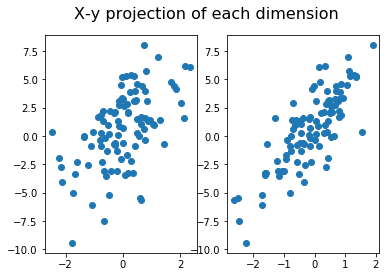

In [6]:
import matplotlib.pyplot as plt
plt.suptitle('X-y projection of each dimension',fontsize=16)
plt.subplot(1,2,1)
plt.plot(X[:,0],y,'o')
plt.subplot(1,2,2)
plt.plot(X[:,1],y,'o')

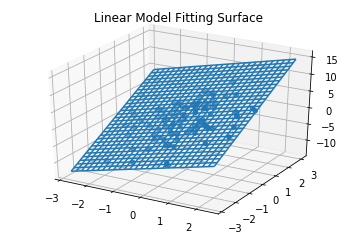

In [7]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d') 
x1=np.arange(-2.8,2.5,0.2)
x2=np.arange(-2.8,3.1,0.2)
x1,x2=np.meshgrid(x1,x2)
Y=lr.coefs_[0]+lr.coefs_[1]*x1+lr.coefs_[2]*x2
ax.plot_wireframe(x1,x2,Y)
ax.scatter(X[:,0],X[:,1],y)
plt.title('Linear Model Fitting Surface')
plt.show()

### Test
It is known that the optimal solution of Least_Graph is:
$$\hat{\beta}=(X^T X)^{-1}Xy$$
Compared with this result, the exactiveness and accuracy of the programme is examined.

In [8]:
print(np.dot(np.dot(np.linalg.inv(np.dot(X_intercept.T,X_intercept)),X_intercept.T),y))

[1.01718095 1.9788676  2.9961769 ]


### Experiment II for Least-Graph (with realistic data)
Data set: **Airfoil Self-Noise Data Set**   
Source from UCI Machine Learning Reposite    
Abstract: NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel.   

This problem has the following features in input $X$:    
* Frequency, in Hertzs. 
* Angle of attack, in degrees. 
* Chord length, in meters. 
* Free-stream velocity, in meters per second. 
* Suction side displacement thickness, in meters.    

The only output $y$ is:    
* Scaled sound pressure level, in decibels.   

Url: https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise
   

In [9]:
import csv
airfoil = np.loadtxt(open("Airfoil.csv","rb"),delimiter=",",skiprows=0)
X = airfoil[:,0:5]
y = airfoil[:,5]
beta = np.arange(1, 7)
print(beta)
# print(X)
# print(y)
lr = LeastGraph()
lr.fit(X, y, beta)

[1 2 3 4 5 6]
iteration 1:
 [ 1.32833806e+02 -1.28220711e-03 -4.21911706e-01 -3.56880012e+01
  9.98540449e-02 -1.47300519e+02]
iteration 2:
 [ 1.32833806e+02 -1.28220711e-03 -4.21911706e-01 -3.56880012e+01
  9.98540449e-02 -1.47300519e+02]


Converge!
iteration 2: [ 1.32833806e+02 -1.28220711e-03 -4.21911706e-01 -3.56880012e+01
  9.98540449e-02 -1.47300519e+02]
 R square = 0.515709742092873
 adjusted R square= 0.5137674014862936
 F = 265.5094273094965
 F0.05 = 2.1046321817124722
 F0.01 = 2.814007643661562
 The regression is extremely significant.



### Experiment III for Least-Graph (with realistic data)
Data set: **Residential Building Data Set Data Set**   
Source from UCI Machine Learning Reposite    
Abstract: Data set includes construction cost, sale prices, project variables, and economic variables corresponding to real estate single-family residential apartments in Tehran, Iran.      

This problem has the 107 features in input $X$:    
* 8 project physical and financial variables 
* 19 economic variables and indices in 5 time lag numbers (5 * 19=95)   
* Others

The 2 outputs in $y$ is:    
* Costs   
* Prices   

Url: https://archive.ics.uci.edu/ml/datasets/Residential+Building+Data+Set   

Because of the occurrance some issues about the accuracy of floating number as we calculate the Hessian matrix and its inverse in Newton method, when the $p$ (the number of $X$ features) grows larger, the process can converge harder.
   

In [10]:
# 18 featrures are selected, and the process converge in 1 iteration
Residential = np.loadtxt(open("Residential.csv","rb"),delimiter=",",skiprows=0)
n,p=Residential.shape
print(n)
print(p)
X = Residential[:,90:107]
y1 = Residential[:,107]
y2 = Residential[:,108]
beta = np.ones(18)
# print(beta)
# # print(X)
# print(y1)
lr1 = LeastGraph()
lr1.fit(X, y1, beta)
lr2 = LeastGraph()
lr2.fit(X, y2, beta)

372
109
iteration 1:
 [-1.16003907e+02  9.69366946e+00  7.01205013e+01 -1.86193253e-03
 -1.10718823e-01 -4.13252618e+00 -5.58194398e-01  3.65584547e-03
 -8.13435136e+00 -9.54306624e-02 -1.10754398e-01  2.85619848e-04
 -7.70124432e-02 -7.33844846e-01  2.73680175e+01 -6.03506141e-03
  3.50180964e-03  1.29973837e-03]
iteration 2:
 [-1.16003899e+02  9.69366944e+00  7.01205009e+01 -1.86193254e-03
 -1.10718822e-01 -4.13252617e+00 -5.58194403e-01  3.65584552e-03
 -8.13435199e+00 -9.54306636e-02 -1.10754398e-01  2.85619709e-04
 -7.70124437e-02 -7.33844445e-01  2.73680172e+01 -6.03506135e-03
  3.50180966e-03  1.29973837e-03]


Converge!
iteration 2: [-1.16003899e+02  9.69366944e+00  7.01205009e+01 -1.86193254e-03
 -1.10718822e-01 -4.13252617e+00 -5.58194403e-01  3.65584552e-03
 -8.13435199e+00 -9.54306636e-02 -1.10754398e-01  2.85619709e-04
 -7.70124437e-02 -7.33844445e-01  2.73680172e+01 -6.03506135e-03
  3.50180966e-03  1.29973837e-03]
 R square = 0.4047157869721167
 adjusted R square= 0.3743

In [11]:
# 28 featrures are selected, and the process converge in 2 iterations
X = Residential[:,80:107]
y1 = Residential[:,107]
y2 = Residential[:,108]
beta = np.ones(28)
# print(beta)
# # print(X)
# print(y1)
lr1 = LeastGraph()
lr1.fit(X, y1, beta)
lr2 = LeastGraph()
lr2.fit(X, y2, beta)

iteration 1:
 [-3.26578420e+02  1.44618375e-01 -5.05032708e-02  1.58130545e-01
  1.14877563e+02  8.12254866e+01  6.52210598e-02 -5.16522275e-03
 -3.20265751e-03  3.08273132e-02 -1.70584635e+01 -1.47204880e+01
 -5.54168089e+01 -1.70587449e-03 -8.76762688e-02 -1.42730482e+00
 -4.96134974e+00  4.12443661e-02  1.68327956e+01  7.78583845e-02
  3.49667946e-01  3.36572144e-02 -1.91797444e-01 -6.93749536e+01
 -6.91302943e+01 -6.07501944e-02  1.45214249e-02  3.17111057e-03]
iteration 2:
 [-3.26578446e+02  1.44618326e-01 -5.05032703e-02  1.58130539e-01
  1.14877566e+02  8.12254843e+01  6.52210615e-02 -5.16522253e-03
 -3.20265750e-03  3.08273191e-02 -1.70584625e+01 -1.47204880e+01
 -5.54168152e+01 -1.70587450e-03 -8.76762690e-02 -1.42730455e+00
 -4.96134977e+00  4.12443663e-02  1.68327948e+01  7.78583823e-02
  3.49667946e-01  3.36572139e-02 -1.91797444e-01 -6.93749518e+01
 -6.91302965e+01 -6.07501941e-02  1.45214250e-02  3.17111057e-03]
iteration 3:
 [-3.26578446e+02  1.44618326e-01 -5.05032703e-

In [12]:
#66 featrures are selected, and the process converge in 14 iterations
X = Residential[:,41:107]
y1 = Residential[:,107]
y2 = Residential[:,108]
beta = np.ones(66)
# print(beta)
# # print(X)
# print(y1)
lr1 = LeastGraph()
lr1.fit(X, y1, beta)
lr2 = LeastGraph()
lr2.fit(X, y2, beta)

iteration 1:
 [ 2.20136000e+05 -2.01844482e+01  7.12789917e+00  2.01132774e-01
 -1.16019440e+00 -1.33063281e+03  3.33152344e+02  4.88543701e+00
 -2.91101074e+00  6.35163784e-02  7.02148438e-01 -4.93081250e+03
  2.06039062e+03  6.80726562e+02 -5.18459320e-01 -1.22334595e+01
 -2.76837891e+02  7.29047852e+01 -5.65181732e-01 -2.54644531e+02
  5.63679504e+00  2.96528320e+01 -6.87709808e-01  9.49511719e+00
 -4.05417969e+02  2.69956250e+03 -5.77838898e-01 -2.99813843e+00
 -9.49778557e-02 -2.34655762e+00 -7.14591797e+02 -5.00910156e+02
  6.65821875e+03  2.25013733e-01  2.99917603e+00  2.85687500e+02
  3.48782349e+01 -4.20249939e-01 -4.92136719e+02  3.91228027e+01
 -3.50998535e+01  9.94453430e-01 -5.29565430e+00  4.51456250e+03
 -3.17809375e+03 -5.92370605e+00 -3.07350159e+00  2.36282349e-02
  2.39615631e+00  4.02790625e+03  1.52941406e+02 -5.42086914e+02
  6.05796814e-01  1.89080811e+00 -8.13121094e+02 -5.45585938e+01
 -7.32551575e-01  1.06734375e+03  1.65307007e+01 -3.42090607e+00
  1.0117645

iteration 11:
 [ 2.20204729e+05 -2.01806596e+01  7.03634221e+00  2.04478491e-01
 -1.15982949e+00 -1.33191066e+03  3.34262643e+02  4.88509382e+00
 -2.91159472e+00  6.35097300e-02  7.04561931e-01 -4.93304715e+03
  2.06167044e+03  6.80345566e+02 -5.18578850e-01 -1.22383366e+01
 -2.77050220e+02  7.29004820e+01 -5.65167665e-01 -2.53615810e+02
  5.62413343e+00  2.96895166e+01 -6.87196136e-01  9.49967926e+00
 -4.06588896e+02  2.70059160e+03 -5.77920750e-01 -2.99862242e+00
 -9.49979820e-02 -2.34782996e+00 -7.13904915e+02 -5.01255775e+02
  6.66096098e+03  2.25174719e-01  2.99894253e+00  2.86155403e+02
  3.48754158e+01 -4.20313027e-01 -4.92628418e+02  3.91327395e+01
 -3.51071361e+01  9.94903514e-01 -5.29674966e+00  4.51562554e+03
 -3.17926425e+03 -5.92561336e+00 -3.07406859e+00  2.36331105e-02
  2.39654661e+00  4.02922430e+03  1.53019515e+02 -5.42166177e+02
  6.05957270e-01  1.89113880e+00 -8.13326324e+02 -5.45774416e+01
 -7.32747219e-01  1.06777210e+03  1.65341654e+01 -3.42038393e+00
  1.012294

In [13]:
#all featrures are selected, and the process cannot converge in 20 iterations!
#This is because of the accuracy of floating number. And it can be solved as we adjust the $eps$ in class NewtonMethod
X = Residential[:,0:107]
y1 = Residential[:,107]
y2 = Residential[:,108]
beta = np.ones(107)
# print(beta)
# # print(X)
# print(y1)
lr1 = LeastGraph()
lr1.fit(X, y1, beta)
lr2 = LeastGraph()
lr2.fit(X, y2, beta)

iteration 1:
 [ 7.02126490e+09 -4.85526433e+17 -1.21381608e+17  4.85526433e+17
  1.21381608e+17 -3.83862682e+07  3.19170180e+05 -1.12168172e+06
  1.81113108e+05 -2.52471553e+05 -1.20738494e+06 -1.21381608e+17
 -7.81029737e+04 -5.01750000e+04 -1.96607900e+06 -8.71628700e+06
  4.49576970e+07 -2.42300000e+03  5.01770000e+04  3.76833000e+05
 -1.96607900e+06  5.63300000e+03 -6.42252700e+06  6.14500000e+03
 -2.31423000e+05  1.62570000e+04 -6.01500000e+03  9.46995300e+06
  1.20913930e+07 -1.45910000e+04  6.20900000e+03 -4.81000000e+02
 -1.95830000e+04  8.65075300e+06  5.57056100e+06 -4.40401910e+07
  5.03000000e+02  4.22500000e+03 -1.93740700e+06 -1.00351000e+05
  1.58730000e+04  2.16268900e+06 -1.51551000e+05  1.67937000e+05
  1.97130000e+04 -6.86070000e+04  3.40787300e+06 -1.27795190e+07
  3.17450000e+04  1.28010000e+04  4.53000000e+02  1.00170000e+04
 -1.41557750e+07  1.45817700e+06 -1.38936310e+07  2.73325000e+03
 -2.91830000e+04  1.83500900e+06  1.00353000e+05  5.18500000e+03
  2.7656193

iteration 11:
 [ 3.02981680e+16 -3.76664092e+24 -9.41660229e+23  3.76664092e+24
  9.41660229e+23 -1.78228187e+14  1.44669658e+12 -4.99578809e+12
  7.36999634e+11 -3.00508250e+12 -4.68349973e+12 -9.41660229e+23
 -3.07653065e+11 -8.76886244e+11  1.12694663e+14 -1.54465759e+14
  2.95027803e+14 -2.40922999e+10  1.18195828e+12  4.05142944e+13
 -3.18858697e+13  1.28430087e+11  2.06498893e+14 -1.95543334e+12
 -3.07514987e+12  3.59443731e+11 -1.82079939e+11  1.00550160e+13
  1.98678720e+13 -3.62728358e+11  1.54175195e+11 -6.61900666e+09
 -1.79734329e+11  7.77715017e+12  1.09655683e+14 -6.15229137e+14
  8.70121753e+09  2.83116591e+11 -1.66413705e+13 -3.56358226e+12
  2.36030870e+11 -4.77763199e+13 -3.31704596e+12  1.84107756e+12
  1.76279949e+11 -9.77687830e+11  8.49461411e+13 -1.94828890e+14
  7.83610435e+11  1.21218584e+11  7.66958988e+09  1.22366747e+11
 -6.76988969e+13  1.95671114e+11 -3.21160363e+14  1.65286454e+10
 -3.50397403e+11  1.23768316e+13  2.10327160e+12  9.46516975e+10
  1.906946

iteration 2:
 [ 1.14395447e+11 -8.99659272e+18 -2.24914818e+18  8.99659272e+18
  2.24914818e+18 -6.35936309e+08  5.33094434e+06 -1.86061378e+07
  2.82017590e+06 -5.59853926e+06 -1.93155973e+07 -2.24914818e+18
 -1.22558260e+06 -1.27231900e+06  4.97418250e+07 -2.25443839e+08
  8.21559297e+08 -4.81990000e+04  1.46944100e+06  3.09657610e+07
 -4.79723510e+07  1.60641000e+05  5.29530890e+07 -1.37215900e+06
 -5.28486300e+06  4.57857000e+05 -1.93151000e+05  1.35233537e+08
  1.75931393e+08 -4.37375000e+05  1.75105000e+05 -1.10590000e+04
 -3.89119000e+05  1.25435905e+08  1.45260545e+08 -9.84350719e+08
  1.24330000e+04  2.42049000e+05 -3.73596150e+07 -3.74169500e+06
  3.72481000e+05 -1.41557750e+07 -4.38476700e+06  3.56454500e+06
  3.88609000e+05 -1.60563100e+06  1.03546881e+08 -3.06380799e+08
  9.35169000e+05  2.57281000e+05  1.15650000e+04  2.17577000e+05
 -2.34225663e+08  1.81698570e+07 -3.97672447e+08  4.76547500e+04
 -6.28223000e+05  3.43244810e+07  2.79756900e+06  1.32289000e+05
  4.9532108

iteration 14:
 [ 4.68455528e+19 -5.14216425e+27 -1.28554106e+27  5.14216424e+27
  1.28554106e+27 -2.89219815e+17  2.42414892e+15 -8.35387888e+15
  1.10569921e+15 -3.61167110e+15 -8.05094109e+15 -1.28554106e+27
 -5.08272495e+14 -9.87631627e+14  1.02698545e+17 -1.72007967e+17
  4.28854523e+17 -2.85236107e+13  1.25422177e+15  3.76421064e+16
 -3.62862192e+16  1.34335083e+14  1.90581295e+17 -1.98757899e+15
 -3.58451163e+15  3.71817785e+14 -2.07848592e+14  4.08597928e+16
  4.64710825e+16 -3.78339030e+14  1.55454470e+14 -7.61493842e+12
 -2.36903399e+14  3.15429506e+16  1.16883954e+17 -6.86535855e+17
  9.42052096e+12  2.70643690e+14 -2.07215010e+16 -3.53852053e+15
  2.71602441e+14 -6.12266651e+16 -3.53124031e+15  2.23854849e+15
  2.29959281e+14 -1.16036613e+15  9.49988363e+16 -2.24607306e+17
  8.25378614e+14  1.71999406e+14  8.75396874e+12  1.38118336e+14
 -9.57859193e+16  1.58508177e+15 -3.23026158e+17  2.24707078e+13
 -4.03055621e+14  1.94602693e+16  2.44683757e+15  1.05236482e+14
  2.478859

### Experiment I for Logistic (with Artificial Data)
A sample with 1000 capacity and 10 dimension is created. Noise follows a normal distribution.   
The process converged after 11 iteration.

In [33]:
# artificial dataset for logistic regression model
#
# Created by ZhuXiangqi 2018.9.16
#
n = 1000
p = 10
beta = np.arange(1, p + 2)
X = np.random.normal(size = (n, p))           
#epsilon = np.random.normal(size = (n))    
X_intercept = np.append(np.ones((n, 1)), X, axis = 1)
#yita = np.dot(X_intercept, beta) + epsilon
yita = np.dot(X_intercept, beta)
p = 1. / (1 + np.exp(- yita))
y = np.array([np.random.binomial(1, pi) for pi in p])
lr = Logistic()
lr.fit(X, y)

iteration 1:
 [-0.0034314   0.06428014  0.21073647  0.30960629  0.3698671   0.3913935
  0.48600829  0.56285452  0.6020052   0.70866046  0.85478972]
iteration 2:
 [0.00914588 0.17484653 0.40211691 0.58619749 0.67994477 0.78276253
 0.92021832 1.0723232  1.19786384 1.35209636 1.55856914]
iteration 3:
 [0.06055471 0.36134211 0.68710897 0.94688823 1.1064856  1.32947039
 1.52157475 1.75491869 2.01913663 2.20883558 2.48556944]
iteration 4:
 [0.17839775 0.61864019 1.09045688 1.44493288 1.71293164 2.07651057
 2.35394187 2.7036144  3.16392291 3.39912482 3.80015964]
iteration 5:
 [0.36480695 0.95061543 1.61896786 2.13161875 2.54856958 3.05191742
 3.45350501 3.99675132 4.68871218 5.01690971 5.62614201]
iteration 6:
 [0.59430463 1.36193186 2.2525475  3.01410291 3.58165965 4.22536952
 4.78576378 5.61737392 6.55234633 7.03976252 7.93901819]
iteration 7:
 [ 0.82861189  1.79758638  2.89533203  3.96694579  4.64148766  5.4232572
  6.15848462  7.33065627  8.49417481  9.18085214 10.39773236]
iteration 8:
 